In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'transects_clim'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [1979,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
input_transect = list()
input_transect.append([[-66, -66],[-67, -55], 'Drake Passage'])
input_transect.append([[-57.0,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
                       [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
                       'OSNAP'])
# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4], 
#                        'OSNAP-West'])
# input_transect.append([[-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP-East'])

#_____________________________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol        = 2 
do_rescale  = None
which_dpi   = 300
which_res   = 0.5
do_ylog     = True
do_contour  = True
do_position = True
do_edgevec_r2g = False

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)

#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
# else:
#     do_reffig=False

#______________________________________________________________________________________________________
# # in case of diff plots
# if (ref_path is not None) and (ref_path is not "None"): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record

#______________________________________________________________________________________________________    
# # concatenate list = list1+list2
# if (ref_path is not None) and (ref_path is not "None"): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths, ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names        

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
 > comp. e_resol from mean
 > comp n_resol from e_resol


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:139: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


Drake Passage


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future v

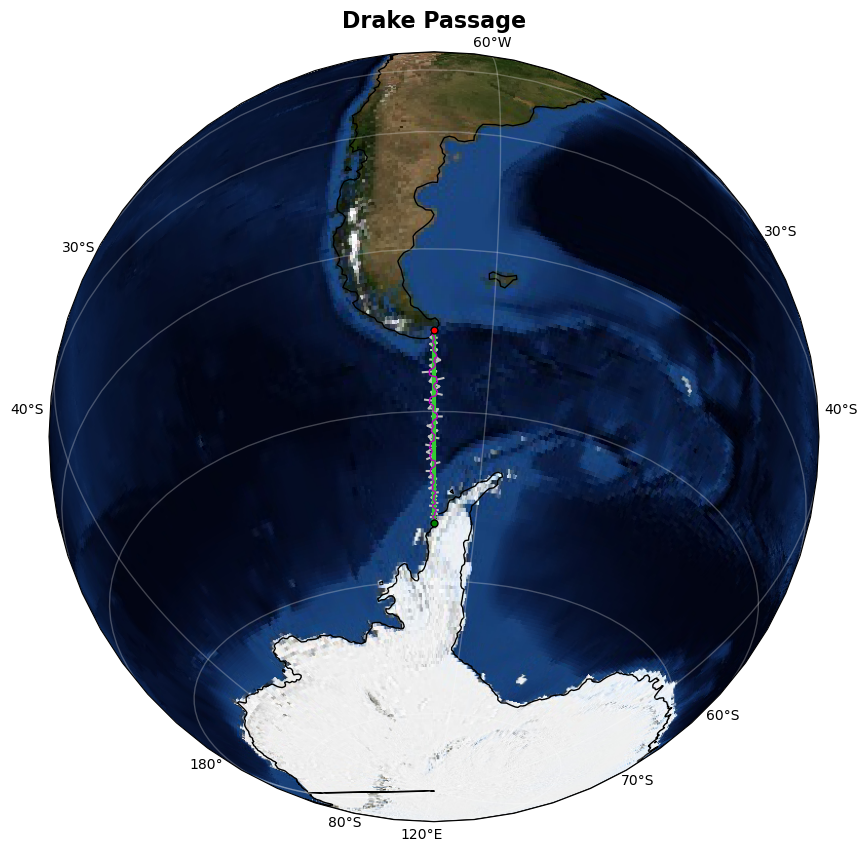

/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,


OSNAP


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future v

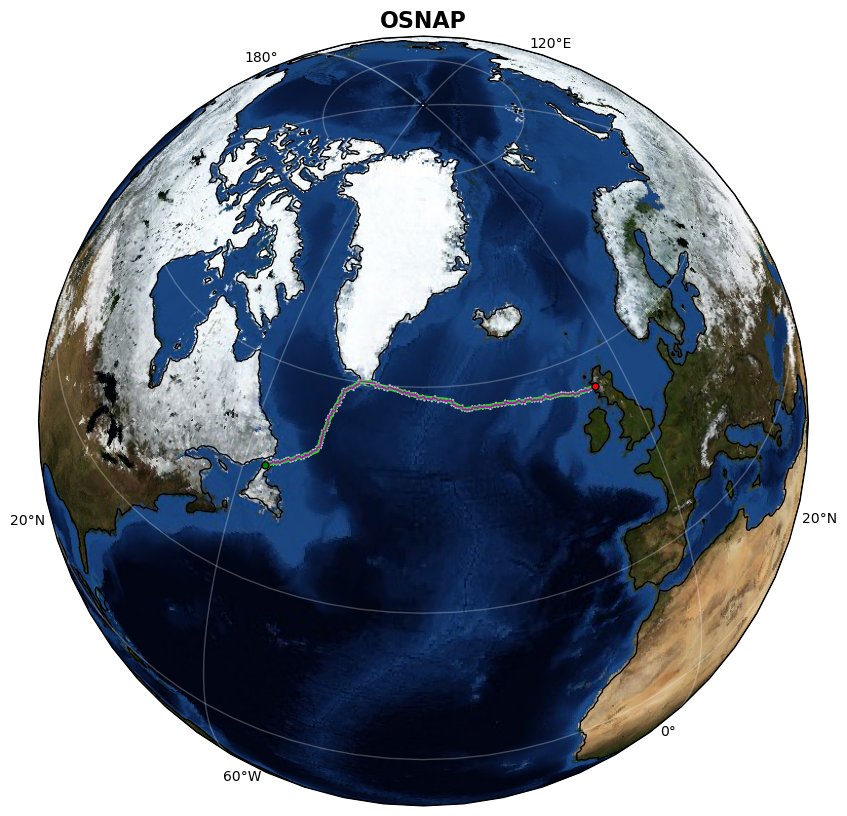

 --> elasped time: 0.055357591311136885 min.


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,


In [5]:
#______________________________________________________________________________________________________    
# load information about edges 
ts = clock.time()
datapath = input_paths[0]
fname    = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy', 'nod_in_elem2D']
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=False, 
                             chunks=dict({'edg_n':'auto'}), engine='netcdf4', 
                             preprocess=partial_func)
mdiag = mdiag.drop_vars(list(mdiag.coords)).load()

# node indices of edge points [2 x n2ded]
edge       = mdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri   = mdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy  = mdiag['edge_cross_dxdy'].values[:]

# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    edm_x = mesh.n_x[edge].sum(axis=0)/2.0
    edm_y = mesh.n_y[edge].sum(axis=0)/2.0
    edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False )
    edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False )
    del(edm_x, edm_y)
    
# [L]eft  triangle: dx, dy
edge_dxdy_l= np.array([ edge_dxdy[0,:], edge_dxdy[1,:]])
# [R]ight triangle: dx, dy
edge_dxdy_r= np.array([ edge_dxdy[2,:], edge_dxdy[3,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist
del(edge_dxdy)

# only needed for plotting transects when scalar data are on elements, here temp and salt are on vertices
# nodeinelem = mdiag['nod_in_elem2D'].values[:,:]-1

#______________________________________________________________________________________________________    
# analyse transects computes all neccesary arrays 
transects = tpv.do_analyse_transects(input_transect, mesh, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
for transect in transects:
    print(transect['Name'])
    fig, ax = tpv.plot_transect_position(mesh, transect, edge=edge)

print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))

In [6]:
#___LOAD CLIMATOLOGY_____________________________________________________________________________________
clim_vname= vname
if vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname: 
    # load climatology data
    ts = clock.time()
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim          = tpv.load_climatology(mesh, clim_path, clim_vname)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> clim uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    print('')

    # compute transect on climatology data
    ts = clock.time()
    clim_csect = tpv.calc_transect_scalar(mesh, clim, transects)
    print(' --> elasped time to comp. clim transect.: {:3.2f} sec.'.format( (clock.time()-ts)  ))   
    for ii, data_ii in enumerate(clim_csect):
        print(' --> clim_transect[{:s}] uses {:3.2f} Mb:'.format(clim_csect[ii][list(clim_csect[ii].keys())[0]].attrs['transect_name'], clim_csect[ii].nbytes/(1024**2)))
    print('')  
    del clim
else: raise ValueError('climatology not supported for choosen vname')   
    
#___LOAD FESOM2 DATA___________________________________________________________________________________
list_transects = list()
for datapath, descript in zip(input_paths, input_names):
    print(datapath, descript)
    ts = clock.time()
    data           = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, descript=descript,
                                          do_info=False, do_zarithm='None', do_ie2n=False, do_nan=False)
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________
    # compute section on data
    ts = clock.time()
    csect = tpv.calc_transect_scalar(mesh, data, transects)
    del(data)
    print(' --> elasped time to comp. data transect.: {:3.2f} sec.'.format( (clock.time()-ts)  ))   
    for ii, data_ii in enumerate(csect):
        print(' --> csect[{:s}] uses {:3.2f} Mb:'.format(csect[ii][list(csect[ii].keys())[0]].attrs['transect_name'], csect[ii].nbytes/(1024**2)))
    print('') 

    # compute anomaly with respect to climatology
    csect = tpv.do_transect_anomaly(csect, clim_csect)
    list_transects.append(csect)
    del(csect)
del(clim_csect)

 --> elasped time to load clim: 0.01 min.
 --> clim uses 0.05 Gb:

 --> elasped time to comp. clim transect.: 0.00 sec.
 --> clim_transect[Drake Passage] uses 0.02 Mb:
 --> clim_transect[OSNAP] uses 0.12 Mb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.30 min.
 --> data uses 0.05 Gb:

 --> elasped time to comp. data transect.: 0.00 sec.
 --> csect[Drake Passage] uses 0.02 Mb:
 --> csect[OSNAP] uses 0.12 Mb:



--> histo: cmin, cmax =  -1.468832771296435 2.409936304933839
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -1.47, 'cmax': 2.41, 'cmap': <matplotlib.colors.ListedColormap object at 0x151f4c92e2b0>, 'clevel': array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5,
       -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,
        0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,
        1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5])}


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future ve

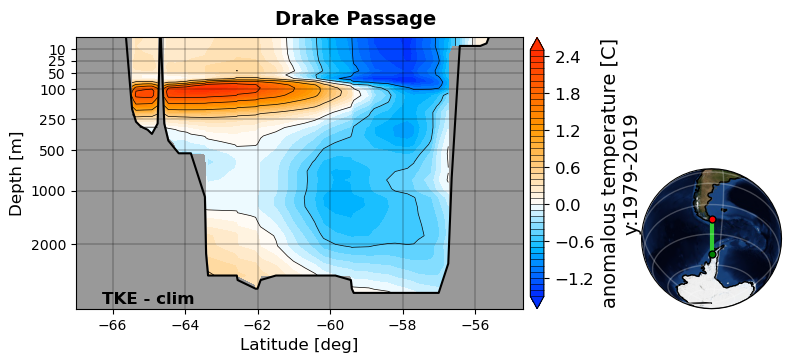

/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,


--> histo: cmin, cmax =  -3.077170318784754 2.316786117011004
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -3.077, 'cmax': 2.317, 'cmap': <matplotlib.colors.ListedColormap object at 0x151ae27dd460>, 'clevel': array([-3.25, -3.  , -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25,
       -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,
        1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ])}


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future ve

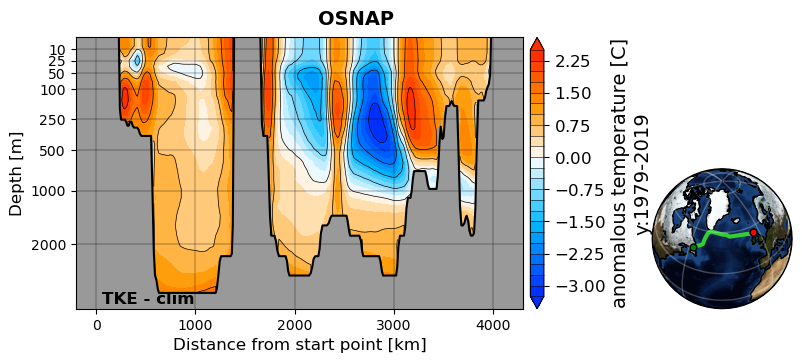

/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/cartopy/crs.py:827: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  multi_line_string = cartopy.trace.project_linear(linear_ring,


In [7]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(list_transects[0][0].keys())[0]
ncol   = np.min([ncol,len(list_transects)]) 
nrow   = np.ceil(len(list_transects)/ncol).astype('int')

for ii in range(len(transects)):
    slabel = list_transects[0][ii][sname].attrs['str_lsave']
    strans = list_transects[0][ii][sname].attrs['transect_name'].replace(' ','_').lower()
    if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, strans, slabel) 
    if save_fname is not None: spath = save_fname
    fig, ax, cbar = tpv.plot_transect(list_transects, transects, tsidx=ii, cinfo=cinfo, figsize=[ncol*7, nrow*3.5], n_rc=[nrow, ncol], 
                                      do_smooth=True, pos_gap=[0.01, 0.01], pos_extend=[0.10, 0.125, 0.85,0.90], do_ylog=do_ylog, 
                                      do_rescale=do_rescale, do_contour=do_contour, do_position=do_position, mesh=mesh, 
                                      do_save = spath, save_dpi=which_dpi, )